In [10]:
import lightkurve as lk

kic_id = 'KIC4762048'
flare_time = 1393.64
quarter = 15

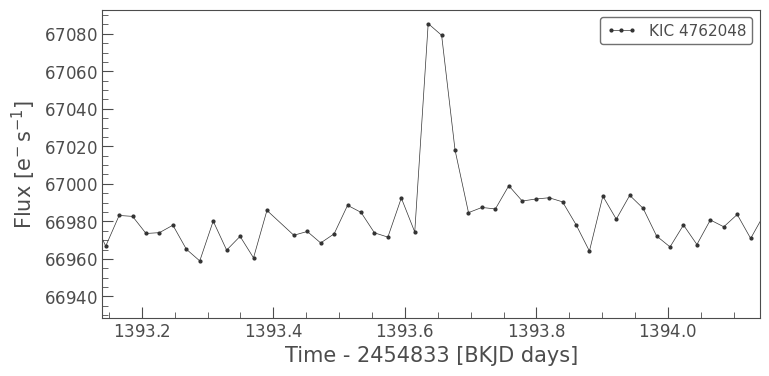

In [11]:
%matplotlib inline
lc = lk.search_lightcurve(kic_id, author="Kepler", cadence="long", quarter=quarter).download()
lc.plot(marker='o').set_xlim(flare_time-0.5, flare_time+0.5);

In [12]:
tpf = lk.search_targetpixelfile(kic_id, author="Kepler", cadence="long", quarter=quarter).download()

In [13]:
from src.flare_localization import FlareLocalization
flare = FlareLocalization(flare_time=flare_time, tpf=tpf)
flare.compute_flare_image()

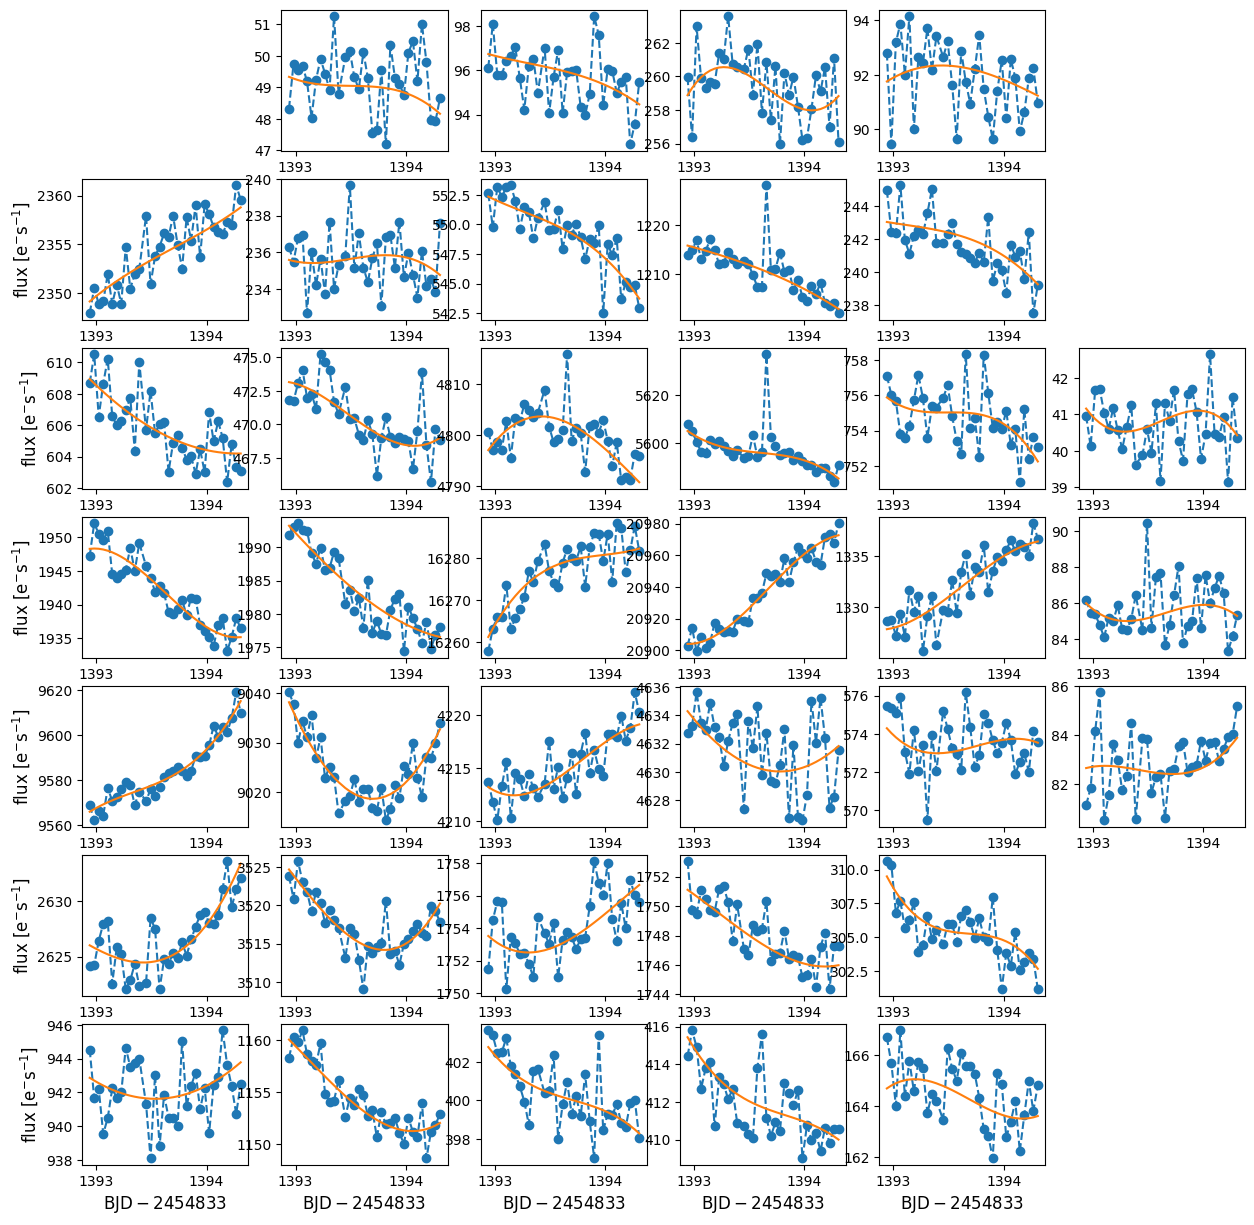

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plotDetrendingPixelFLuxes(time: np.ndarray, flux: np.ndarray, mean_flux: np.ndarray) -> None:
    n_xpix = flux.shape[1]
    n_ypix = flux.shape[2]
    plt.figure(figsize=(15,15))
    c=1
    for i in range(n_xpix):
            i= n_xpix - 1 - i
            for j in range(n_ypix):
                if not(np.isnan(flux[0, i, j])):
                    plt.subplot(n_xpix, n_ypix, c)
                    plt.plot(time, flux[:, i, j], "o--")
                    plt.plot(time, mean_flux[:, i, j], "-")
                    if j == 0:
                        plt.ylabel(r"$\mathrm{flux}$ $[\mathrm{e}^{-} \mathrm{s}^{-1}]$", fontsize=12)
                    if i ==0:
                        plt.xlabel( r"$\mathrm{BJD  -  2454833}$" , fontsize=12)
                c = c + 1
    plt.show()

plotDetrendingPixelFLuxes(time=flare.flare_image.time_within_window_with_flare,
                          flux=flare.flare_image.tpfs_within_window_with_flare,
                          mean_flux=flare.flare_image.quiet_stellar_fluxes_within_window_with_flare)


In [15]:
flare.localize_flare()

center_of_brightness = (2.9654814400390137, 2.630688713239758)
p0: [360.63068871323975, 933.965481440039, 371.25534296035767, 10.033928188117775]
p0: [361.37158187336433, 935.702314377421, 102.50533959840267, 7.381786023235998]
flare col : 360.87300828626354 - 0.09264200146719759 + 0.09158831149750313
flare row : 935.2067148636309 - 0.08943896970822607 + 0.08012694469755388
flare flux : 102.16638737347074 - 13.08545523168388 + 13.759475611627934
offset flux $[e^{-1}s^{-1}]$ : 7.3717242491285795 - 0.4961880066894713 + 0.5201769968233085


In [16]:
flare.get_gaia_data()
print(flare.gaia_data)

       _r               Source     RA_ICRS    DE_ICRS     Gmag    pmRA  \
0  11.142  2076324118740316672  295.742730  39.897160  20.7492  -0.228   
1  14.009  2076324221831479296  295.747675  39.902933  15.7351   2.228   
2   5.597  2076324217530618368  295.743528  39.899850  17.3767  -2.221   
3   4.624  2076324221820860160  295.744278  39.900322  20.0440  11.365   
4   0.211  2076324221831476608  295.745554  39.899429  13.1703   9.067   
5   9.736  2076324221831478528  295.749003  39.899437  13.9472  -0.991   
6   7.253  2076324221819535104  295.744796  39.897480  19.9871  -2.774   

   e_pmRA   pmDE  e_pmDE  pmRApmDEcor     Plx   e_Plx  PlxpmRAcor  PlxpmDEcor  
0   1.876 -2.638   1.987      -0.2947  0.1653  1.4866     -0.0090     -0.3331  
1   0.057  1.130   0.054      -0.0504  0.5998  0.0327     -0.1766     -0.1456  
2   0.131 -6.582   0.130       0.0495  0.0205  0.0759     -0.1233     -0.0614  
3   0.844  8.637   0.814       0.2244  1.2697  0.4712     -0.1890     -0.0416  
4   0.0

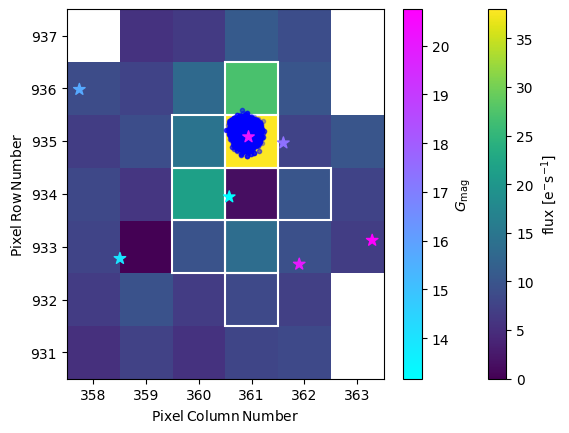

In [18]:
import matplotlib.cm as cm
from matplotlib import patches
def plot_apperture_mask(ax, tpf):
    aperture_mask = tpf.pipeline_mask
    for i in range(aperture_mask.shape[0]):
        for j in range(aperture_mask.shape[1]):
            if aperture_mask[i, j]:
                rect = patches.Rectangle(
                    xy=(j + tpf.column - 0.5, i + tpf.row - 0.5),
                            width=1,
                            height=1,
                            edgecolor="white",
                            fill=False,
                            linewidth = 1.5,
                            alpha=1.0
                        )
                ax.add_patch(rect)


def plot_residual_flare_with_mcmcm(flare, ax, extend):
    flare_image = flare.flare_image.flare_image+abs(np.min(flare.flare_image.flare_image[~np.isnan(flare.flare_image.flare_image)]))
    im = ax.imshow(flare_image, origin ="lower", extent = extend,  vmin=0,vmax=38 )
    ax.plot( flare.mcmc.chain[:,0], flare.mcmc.chain[:,1] , "b.", alpha=0.3)
    ax.set_xlabel("$\mathrm{Pixel \, Column \, Number}$")
    sccatter = ax.scatter( flare.star_positions[:, 0], flare.star_positions[:,1],  c=flare.gaia_data.Gmag, \
            s=75, marker="*", cmap=cm.cool, label = "J2015.5", zorder=100000000000)
    return im, sccatter



fig, ax = plt.subplots()
extend = [tpf.column-0.5, tpf.column + flare.flare_image.flare_image.shape[1]-0.5, tpf.row-0.5, tpf.row + flare.flare_image.flare_image.shape[0]-0.5]
plot_apperture_mask(ax, tpf)
im, sccatter = plot_residual_flare_with_mcmcm(flare, ax, extend)
ax.set_ylabel("$\mathrm{Pixel \,  Row \, Number}$")
cb = fig.colorbar(im)
cb.set_label(r"$\mathrm{ flux}$ $[\mathrm{e}^{-} \mathrm{s}^{-1}]$")
cbb = fig.colorbar(sccatter)
cbb.set_label(r"$G_\mathrm{mag}$")